# 波士顿房价探索性数据分析
<img src="./images/boston_analysis_toc.png">

## 1.数据加载

In [1]:
import warnings
import pandas as pd  # 数据分析库
import numpy as np  # 矩阵计算
import matplotlib.pyplot as plt  # 画图

import plotly.express as px  # 画图
from statsmodels.graphics.gofplots import qqplot  # 统计模型
import seaborn as sns  # 统计绘图
%matplotlib inline

# 避免产生报警告
warnings.filterwarnings('ignore')

In [2]:
# 加载数据
# 参考链接：https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston
# data_url = "http://lib.stat.cmu.edu/datasets/boston" # 数据来源
# raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None) # 用pandas读csv文件
# data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
# target = raw_df.values[1::2, 2]

In [3]:
house = pd.read_csv("./data/boston.csv")
house.head() # 读前五行

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


1.1特征说明
- CRIM：按城镇划分的人均犯罪率
- ZN：划分为超过 25,000 平方英尺地块的住宅用地比例
- INDUS：每个城镇的非零售商业用地的比例
- CHAS：Charles River 虚拟变量（如果区域以河流为界，则为 1；否则为 0）
- NOX：一氧化氮浓度（每 1000 万分之一）
- RM：每户住宅的平均房间数
- AGE：1940 年之前建造的自住单元的比例
- DIS：到波士顿五个就业中心的加权距离
- RAD：通往径向高速公路的指数
- TAX：每 10,000 美元的价值财产税率
- PTRATIO：按城镇划分的师生比例
- B：等式 $B=1000(Bk - 0.63)^2$ 的结果，其中 $Bk$ 是城镇中黑人的比例
- LSTAT：人口地位较低的百分比

标签：

MEDV：1000 美元自住房屋的中位数价值

## 2.数据概况

数据集总共有506行, 也就是有506套房子的数据；有14列，其中13列是特征，也就是每个房子会有13个属性特征，例如：住宅的房间数、交通方便度等信息，最后一列是房子的标签——房价. 这个数据集主要的一个想法是，利用房子的13个属性特征，对房子的价格进行预测

In [4]:
# 数据的规模
house.shape

(506, 14)

In [5]:
# 基本统计描述
house.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


2.1处理思路

- 缺失值：从第一行我们可以看到所有的```count```也就是数目统计，所有特征都是506等于样本数的，说明这个数据集至少是没有缺失值的
- 异常值：```CRIM```列是犯罪率，是一个在$[0,1]$之间的实数，75%分位数最大值不可能超过1，所以显然这一列的数据是有异常的
- 降维：```TAX```列的方差非常的大，可以采用一些降维的手段如：主成分分析（PCA）

In [6]:
# 查看数据有无缺失值, 变量的数据类型, 通过变量类型分析数据处理的方法
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


## 3.数据处理
### 3.1缺失值处理

In [7]:
# 加载手动删除了一些数据的数据集
null_data = pd.read_csv("./data/boston_null.csv")
null_data.head()  # 读前五行

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,NaN,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [8]:
# 样本总数为506，非空值不等于506的即为含有缺失值的特征
null_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      504 non-null    float64
 5   RM       504 non-null    float64
 6   AGE      505 non-null    float64
 7   DIS      491 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        453 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


缺失值计数

In [9]:
null_data.isnull().sum()

CRIM        0
ZN          0
INDUS       0
CHAS        0
NOX         2
RM          2
AGE         1
DIS        15
RAD         0
TAX         0
PTRATIO     0
B          53
LSTAT       0
MEDV        0
dtype: int64

缺失值可视化-柱状图

<AxesSubplot:>

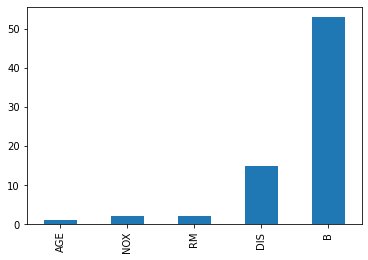

In [10]:
# 缺失值可视化
missing = null_data.isnull().sum()
missing = missing[missing > 0]  # 筛选出有缺失值（大于0）的特征
missing.sort_values(inplace=True)  # 排序
missing.plot.bar()  # 调用pandas内置的条形图绘制

缺失值可视化-热力图

这种方式还可以帮助我们看出缺失的位置，如果有些样本出现大量特征缺失的情况，在样本足够大的情况下也可以考虑删除这些特征

In [11]:
null_data.isnull()  # 查看每一列的缺失值情况, 得到一个bool型的数据

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,False,False,False,False,False,False,False,False,False,False,False,False,False,False
502,False,False,False,False,False,False,False,False,False,False,False,False,False,False
503,False,False,False,False,False,False,False,False,False,False,False,False,False,False
504,False,False,False,False,False,False,False,False,False,False,False,False,False,False


<AxesSubplot:>

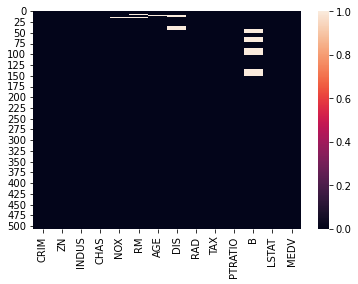

In [12]:
sns.heatmap(null_data.isnull())  # 热图, y坐标轴可以不显示, x坐标轴为特证名称

缺失值比例统计

统计每一个特征的缺失比例，如果**缺失值超过95%的特征**，会考虑删除它

In [13]:
lst = []
for col in null_data.columns:
    lst.append((col, null_data[col].isnull().sum() * 100 / null_data.shape[0]))
lst = sorted(lst, reverse = True, key=lambda x: x[1])  # 按缺失值比例降序排列
pd.DataFrame(lst, columns=['Features', 'missing rate'])

,Features,missing rate
0,B,10.474308
1,DIS,2.964427
2,NOX,0.395257
3,RM,0.395257
4,AGE,0.197628
5,CRIM,0.000000
6,ZN,0.000000
7,INDUS,0.000000
8,CHAS,0.000000
9,RAD,0.000000


In [14]:
# 不使用for循环和append方法
new_df = pd.DataFrame((null_data.isnull().sum() * 100 / null_data.shape[0])
             .sort_values(ascending=False).round(2), 
             columns=['missing rate']).reset_index()
new_df.columns = ['Features', 'missing rate']
new_df
# (null_data.isnull().sum() / null_data.shape[0]).sort_values(ascending=False).map(lambda x: "{:.2%}".format(x))  # 输出百分比

,Features,missing rate
0,B,10.47
1,DIS,2.96
2,NOX,0.40
3,RM,0.40
4,AGE,0.20
5,CRIM,0.00
6,ZN,0.00
7,INDUS,0.00
8,CHAS,0.00
9,RAD,0.00


In [15]:
# 特征不同取值的个数，方差特别小或者说取值唯一的特征是没有意义的，可以考虑删除
null_data.nunique()  # 采用 df.nunique() 来统计每个每个特征会有多少个不同取值

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         445
AGE        356
DIS        401
RAD          9
TAX         66
PTRATIO     46
B          326
LSTAT      455
MEDV       229
dtype: int64

In [16]:
def df_stats(df):
    '''
    统计该df的缺失值，比例以及唯一值个数
    '''
    lst = []
    for col in df.columns:
        lst.append((col,
                    df[col].isnull().sum(),
                    df[col].isnull().sum() * 100 / df.shape[0],
                    df[col].nunique()))
    res = pd.DataFrame(lst, columns=['Feature', 'missing num', 'missing rate', 'unique num'])
    return res

In [17]:
df_stats(null_data)  # 合并数据

,Feature,missing num,missing rate,unique num
0,CRIM,0,0.000000,504
1,ZN,0,0.000000,26
2,INDUS,0,0.000000,76
3,CHAS,0,0.000000,2
4,NOX,2,0.395257,81
5,RM,2,0.395257,445
6,AGE,1,0.197628,356
7,DIS,15,2.964427,401
8,RAD,0,0.000000,9
9,TAX,0,0.000000,66


In [18]:
# 粗暴的用均值填充缺失值
null_data = null_data.fillna(null_data.mean())  # 用均值填充

<AxesSubplot:>

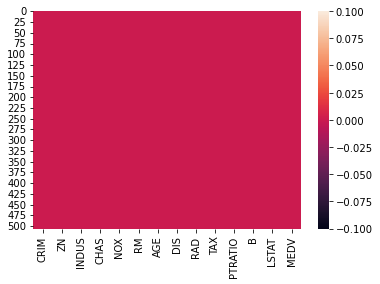

In [19]:
sns.heatmap(null_data.isnull())  # 可见现在已经没有缺失值了

### 3.2变量分析

在变量分析中，我们延续了在概率论与数理统计中的研究思想

在概率论与数理统计中，首先研究了单变量随机变量的性质与特征刻画，转而研究随机变量之间的关系

在数据分析中亦是如此，先分析一个变量的情况，比如：数据类型、分布情况、是否有离群值等，转而研究变量之间的关系：相关性分析、分组统计等

<img src="./images/feature_analysis.png">


#### 3.2.1 单变量分析

分析标签

首先是对于数据集标签的分析，要明白任务的需求

数据挖掘任务主要分为两类：**回归**与**分类**

回归是指标签值是连续值的任务，例如我们用到的这个数据集，要求预测房价信息，房价是一个连续的变量，因此这样的任务属于**回归问题(Regression)**

经典的数据集——鸢尾花(Iris)数据集，它收集了三种鸢尾花的萼片长度，宽度等信息，要求你根据这些信息预测鸢尾花属于哪种类别，因此它的标签就是1，2，3，代表三类鸢尾花. 像这种标签是离散的数据分析任务就属于**分类任务**.

In [20]:
house["MEDV"].nunique()  # 看看MEDV这个特征有多少个不同取值

229

回归型任务

从标签的取值上，我们可以大致判断出本次任务属于回归型任务，因为它的取值个数比较多. 但这不是判断的标准，只是一个判断的参考，主要还是要分析题目的任务需求.

In [21]:
# 打印标签的统计信息
house["MEDV"].describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: MEDV, dtype: float64

标签的统计信息

从标签列的统计信息我们可以大致看出，其分布还算比较正常，没有太大的方差（方差太大说明数据不太可能是正态的，因为够不集中）. 

也没有出现我们在前面提到的，在定义域之外的值出现（离群值可通过箱线图或者散点图等可视化分析判断）. 

<AxesSubplot:xlabel='MEDV', ylabel='Density'>

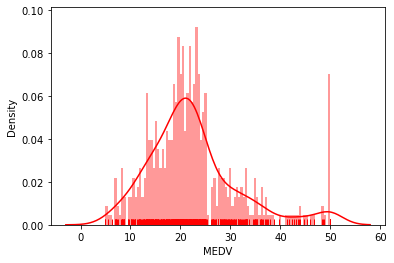

In [22]:
# 画出其密度分布图，看看标签取值的总体分布情况
plt.figure()
sns.distplot(house["MEDV"],
             bins=100,  # 柱子的个数
             hist=True,  # 是否绘制直方图
             kde=True,  # 是否绘制密度图
             rug=True,  # 数据分布标尺
             color='r',  # 颜色
             # vertical=False,  #是否水平绘制
             # norm_hist=False,  #标准化，kde为True时自动标准化
             axlabel=None,  # x轴标注
             label=None,  # 图例标签，通过plt.legend()显示
             ax=None,
             )


密度分布图（原始数据）

我们看到整个分布稍微有一点右偏，因此在实战中，我们可以采用**对数化**的方法，让标签分布接近正态.

<AxesSubplot:xlabel='MEDV', ylabel='Density'>

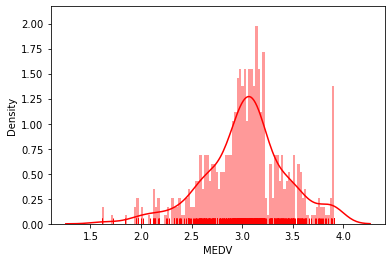

In [23]:
plt.figure()
sns.distplot(np.log(house["MEDV"]),  # 用对数绘制
             bins=100,  # 柱子的个数
             hist=True,  # 是否绘制直方图
             kde=True,  # 是否绘制密度图
             rug=True,  # 数据分布标尺
             color='r',  # 颜色
             # vertical=False,#是否水平绘制
             # norm_hist=False,#标准化，kde为True时自动标准化
             axlabel=None,  # x轴标注
             label=None,  # 图例标签，通过plt.legend()显示
             ax=None,
             )


密度分布图（对数变换）

这样的变换之后，我们到时候可以将取值小于1.5的取值视为异常值，将其抛弃掉. 

对于分类任务而言，我们也可以采用此法画出它的频率分布直方图，或者直接更直接的画图条形统计图.

如果分类的标签分布是相似的，那么我们可以直接建模. 

但如果标签出现很明显的一高一低的情况，说明**标签的分布不均衡**，那再建模前需要做一些操作（例如：欠采样、调整损失函数），再进行建模. 

否则会出现一个问题，模型会对出现频率低的样本非常不敏感. 

这就好像数学考试前的复习题，大多数都是数列题，只有一个是立体几何题目，大家花了很多精力研究数列，结果一到考试，出现了很多立体几何的题目，这时候我们复习的效果其实会显得很差. 模

型训练的过程就类似考前复习的过程，所以我们在建模前要尽量保证标签的均衡性.

离散型变量（类别型变量）

对于类别型变量而言，一般观察其分布我们采用柱状图的方式.

In [24]:
# 表的最后一列可以看出CHAS, RAD这样的变量的取值比较符合分类变量的特征，同时阅读特征说明亦可得以确认
df_stats(null_data)

,Feature,missing num,missing rate,unique num
0,CRIM,0,0.0,504
1,ZN,0,0.0,26
2,INDUS,0,0.0,76
3,CHAS,0,0.0,2
4,NOX,0,0.0,82
5,RM,0,0.0,446
6,AGE,0,0.0,357
7,DIS,0,0.0,402
8,RAD,0,0.0,9
9,TAX,0,0.0,66


array([[<AxesSubplot:title={'center':'CHAS'}>,
        <AxesSubplot:title={'center':'RAD'}>]], dtype=object)

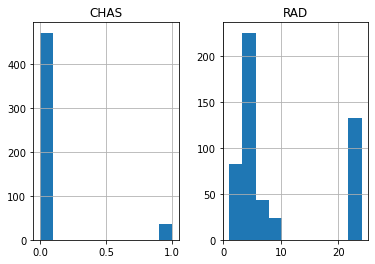

In [25]:
# 类别型变量更大的作用：是用于后续在特征工程中，用于进行特征交叉，继续特征的增强，挖掘更深层次的潜在信息
house[['CHAS', 'RAD']].hist()  # 画出两个特征的直方图

连续型变量（数值型变量）

array([[<AxesSubplot:title={'center':'CRIM'}>,
        <AxesSubplot:title={'center':'ZN'}>,
        <AxesSubplot:title={'center':'INDUS'}>],
       [<AxesSubplot:title={'center':'NOX'}>,
        <AxesSubplot:title={'center':'RM'}>,
        <AxesSubplot:title={'center':'AGE'}>],
       [<AxesSubplot:title={'center':'DIS'}>,
        <AxesSubplot:title={'center':'TAX'}>,
        <AxesSubplot:title={'center':'PTRATIO'}>],
       [<AxesSubplot:title={'center':'B'}>,
        <AxesSubplot:title={'center':'LSTAT'}>, <AxesSubplot:>]],
      dtype=object)

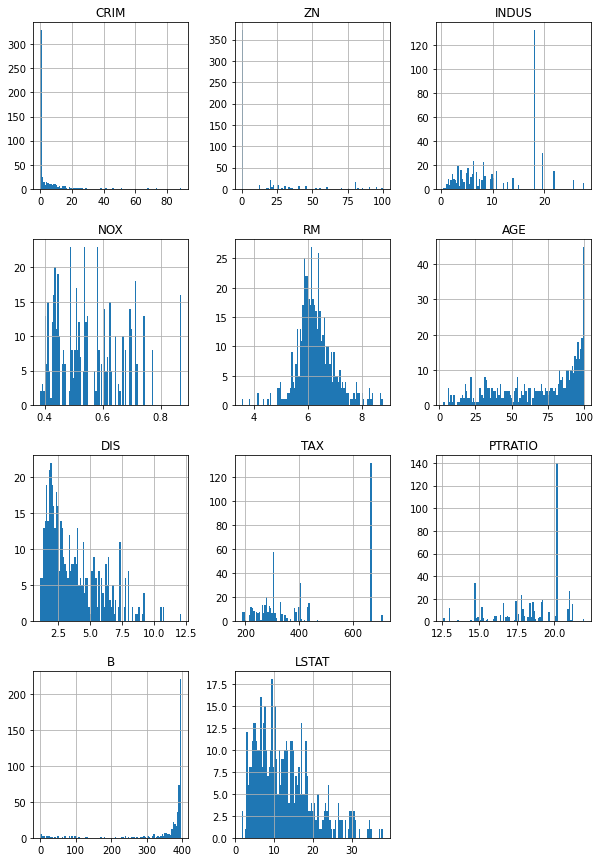

In [26]:
house[['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']].hist(figsize = (10, 15), bins = 100)  # 画出十二个特征的直方图

变量之间的相关性和共线性

从上面的图像可以看出，有些变量实际上是有相似（A高B高）的分布情况的，或者相反的分布情况的（A高B低）, 这样的性质称为**变量之间的相关性**. 相关性一般有两种情况：
- **正相关**：如果特征A的增加（减少）会导致特征B增加（减少），即特征A与特征B变化趋势相同.
- **负相关**：如果特征A的增加（减少）会导致特征B减少（增加），即特征A与特征B变化趋势相反.

当两个变量呈正相关或者负相关时，我们称两个变量是相关的. 如果两个变量有较强的相关性时，如果将这些变量一起用的话，会有很多是冗余的. 因为这样变量之间有较强的相关性，那么变量与变量之间是可以相互表示的，所以在建模时，需要尽可能消除特征之间的**共线性**，也就是尽量使用相关性比较小的特征，这样可以减少训练时间，使得模型的学习效果更好.

#### 3.2.2 多变量分析


##### 相关性

从可视化的角度来研究变量之间的相关性

对于可视化而言，最简单的方式就是将两个特征对应的坐标点在坐标系下描出来，研究他们的变化趋势

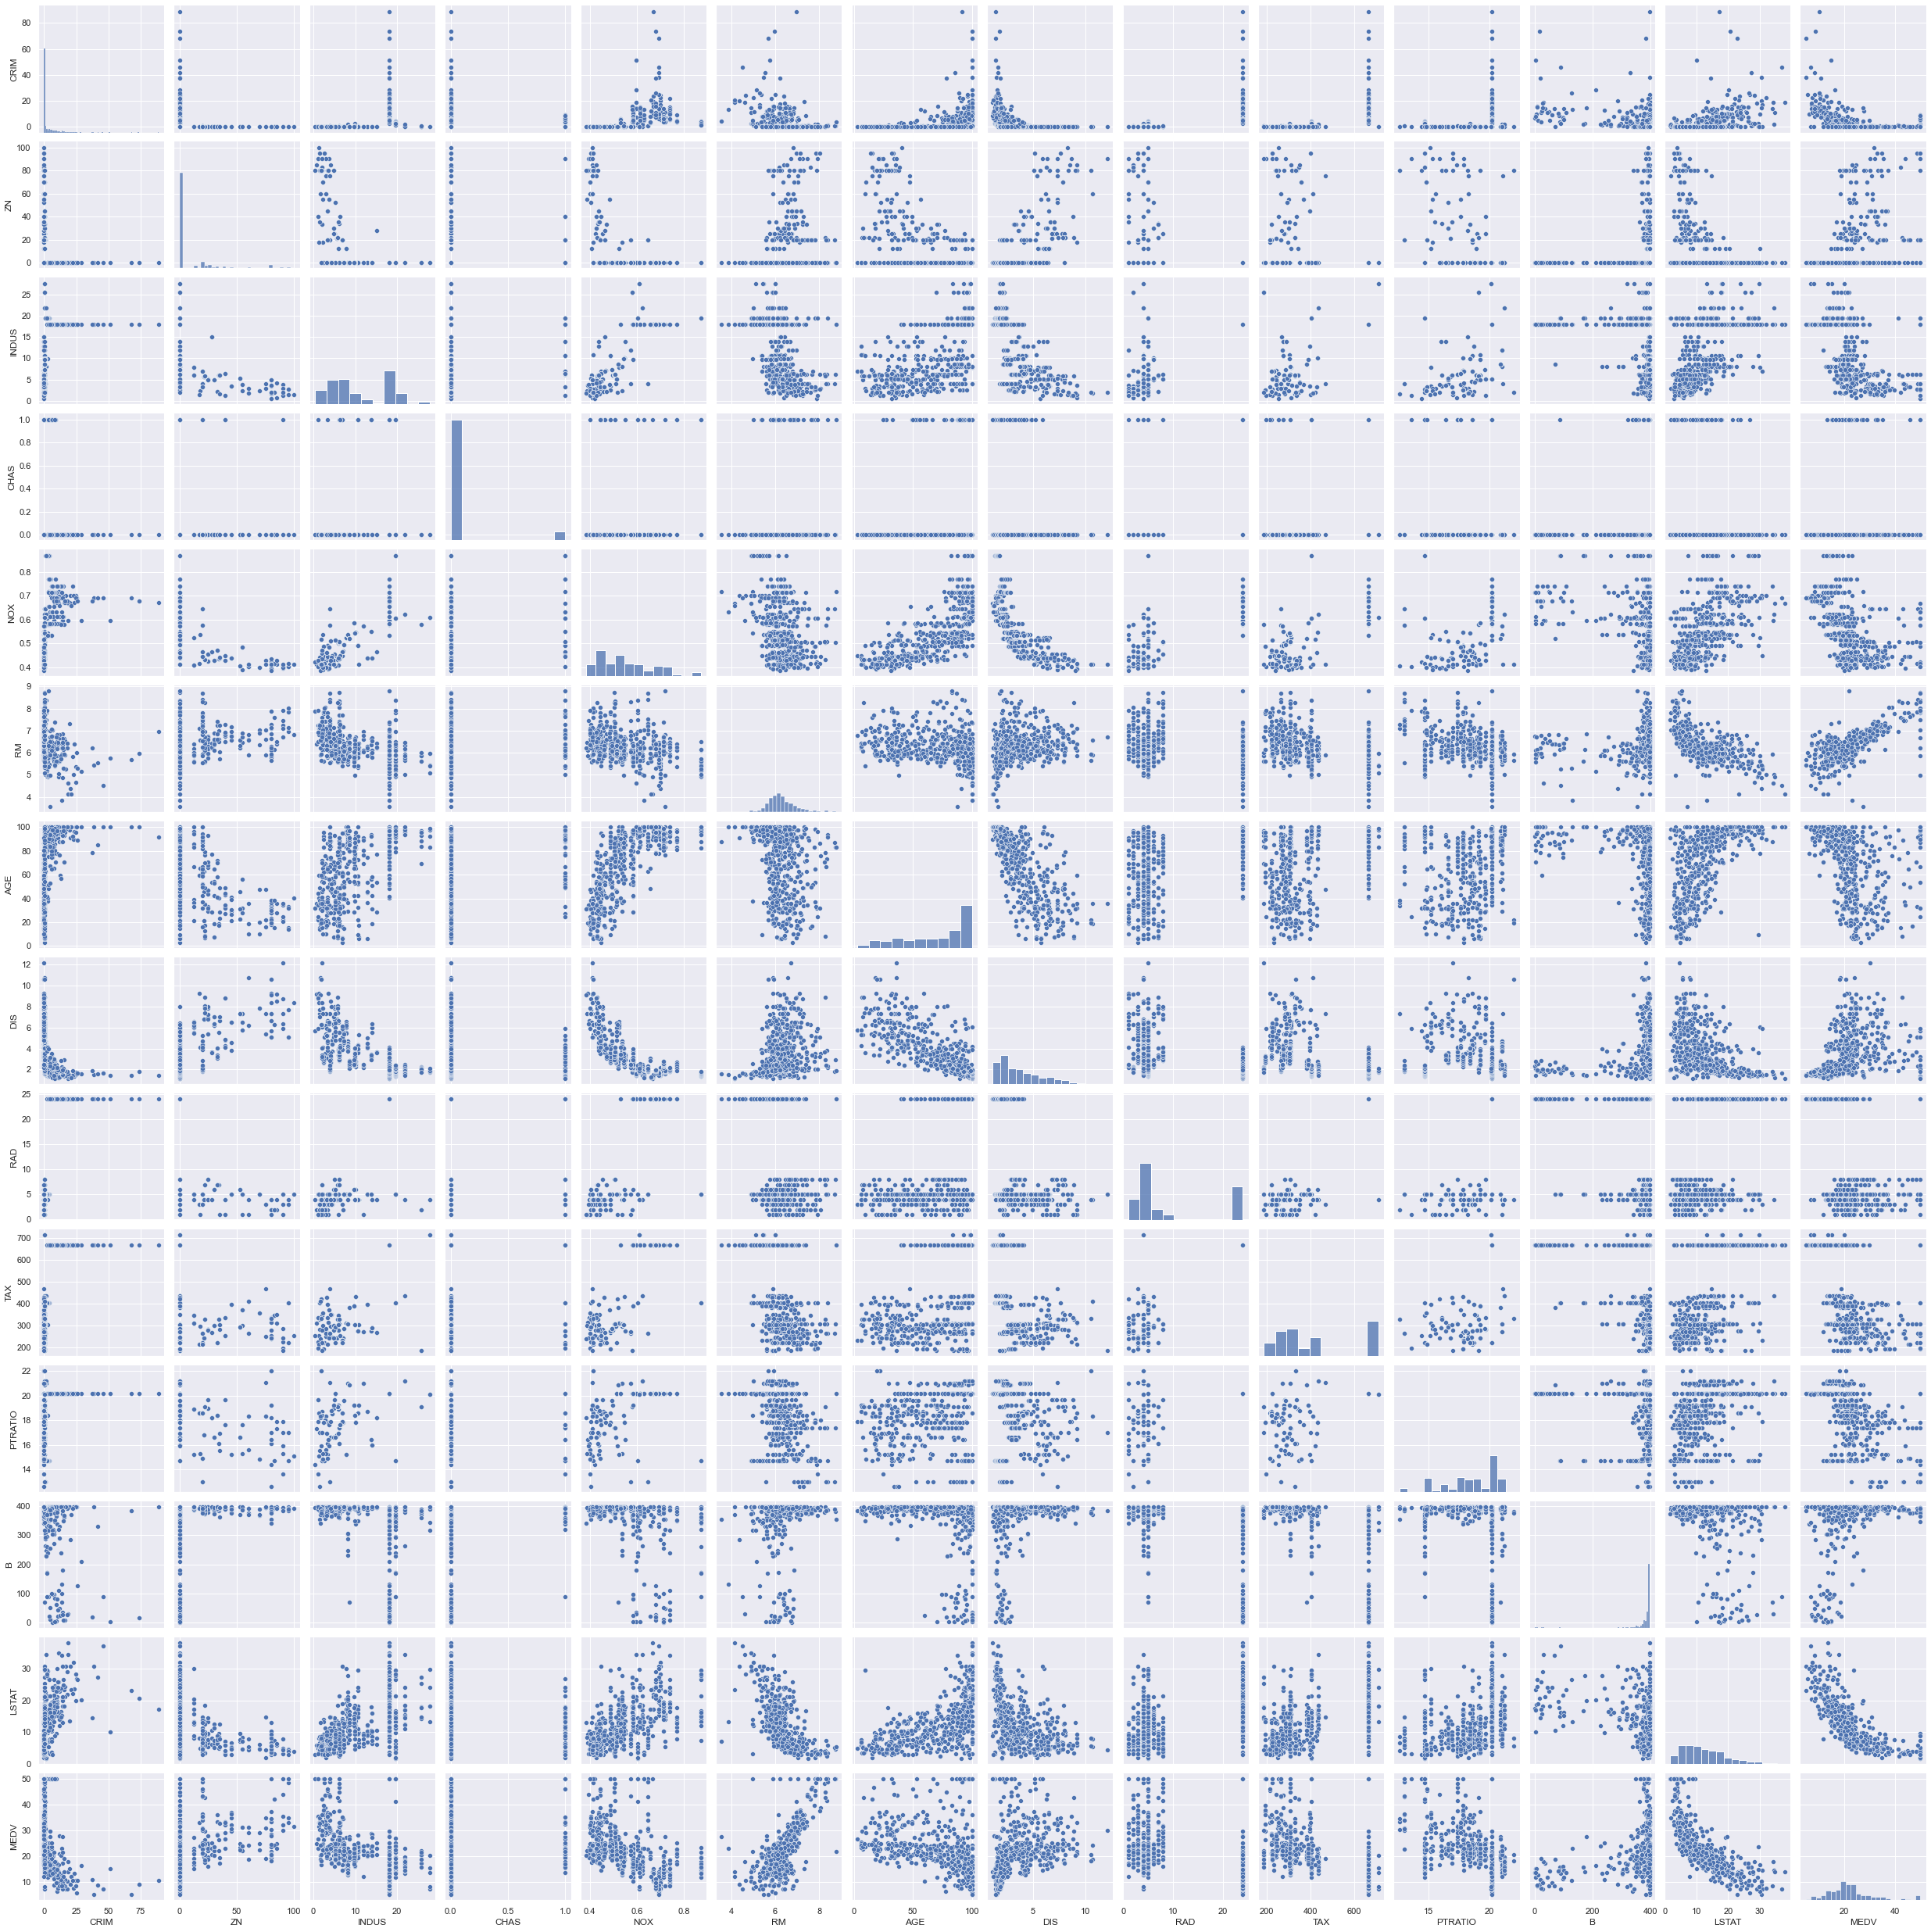

In [27]:
# 任意两个变量间的相关性散点图
sns.set()
cols = house.columns  # 罗列出数据集的所有列
sns.pairplot(house[cols], size=2.5)  # 成对画出任意两列的散点图
plt.show()

直线函数图像

首先，我们先看图像呈“对角线分布的”，即```/```或者```\```这两种类型分布的图像，这样的图像说明这两个变量间有较强的相关性，是可以被消除共线性的“嫌疑对象”. 如图中的```DIS```和```AGE```,尽管他不是严格的直线分布，但至少其分布呈现带状；


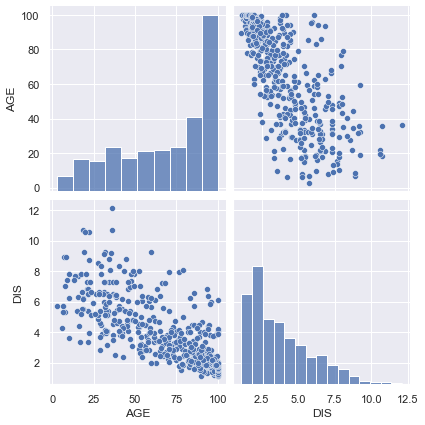

In [28]:
sns.pairplot(house[["AGE", "DIS"]], size=3)  # 成对画出任意两列的散点图, size是点的大小

对数函数图像

其次，我们可以看那些趋势比较明显单调，但是不太像直线，而是类似于“对数函数”的图像，例如图中的```DIS```和```NOX```,因为这类图像，只要做一下对数化，马上就可以得到类似直线的效果，那么也是可以被处理的.

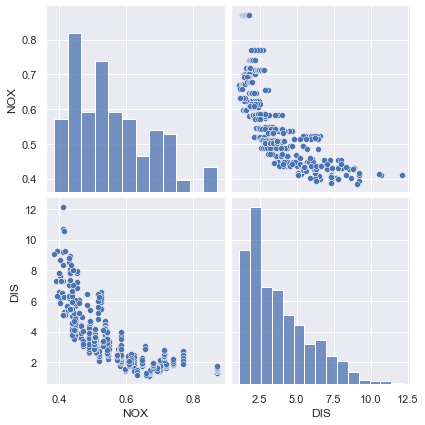

In [29]:
# 对数函数图像
sns.pairplot(house[["NOX", "DIS"]], size = 3) # 成对画出任意两列的散点图, size是点的大小

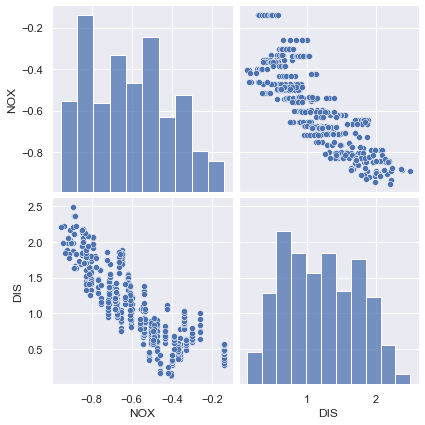

In [30]:
# 对数据做对数变换
sns.pairplot(np.log(house[["NOX", "DIS"]]), size = 3) # 成对画出任意两列的散点图, size是点的大小

特征与标签的关系

我们还需要关注最后一行（列）与其他行（列）的关系，也就是特征与标签的关系，如果这两者出现了较强相关性，那么这些特征我们需要留意，因为这些特征对标签有着比较直接的关系，例如```RM```和```LSTAT```.

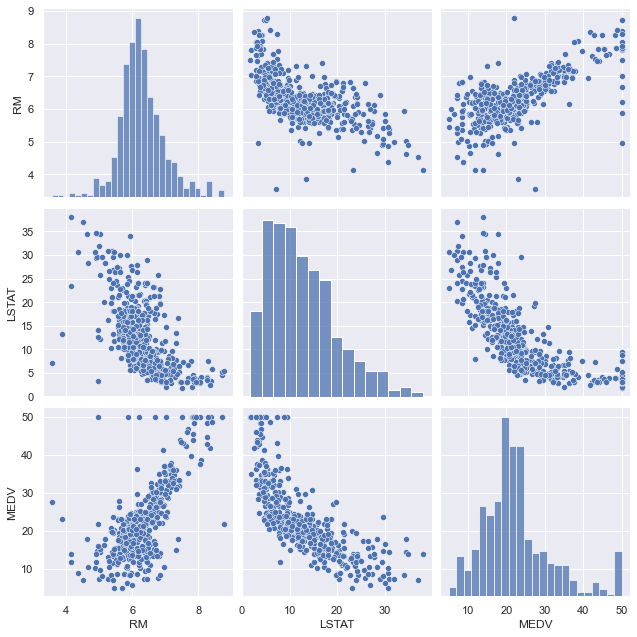

In [31]:
# 原始数据
sns.pairplot(house[["RM", "LSTAT", "MEDV"]], size=3)  # 成对画出任意两列的散点图, size是点的大小

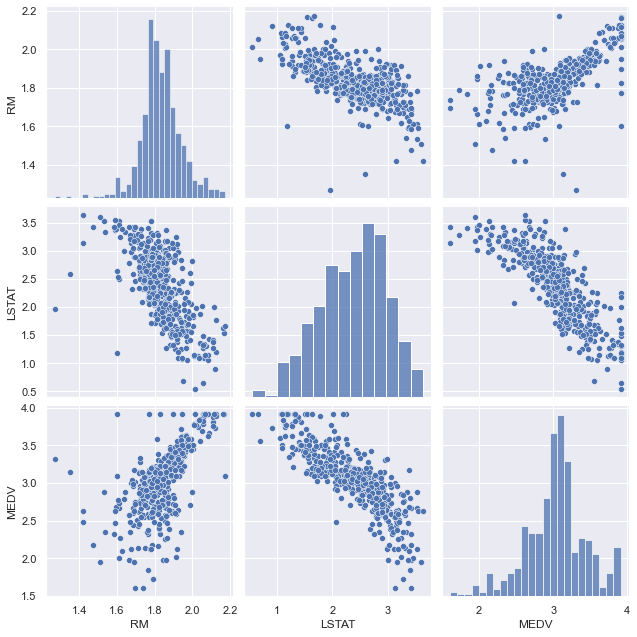

In [32]:
# 对数函数图像
sns.pairplot(np.log(house[["RM", "LSTAT", "MEDV"]]), size=3)  # 成对画出任意两列的散点图, size是点的大小

协方差

但是仅仅从图像上去看还是太过于感性了，只能大致的判断出趋势，那么有没有办法刻画“两个特征非常相关”，又或者“两个变量没那么相关”呢？答案是肯定的，大家可以回想一下我们在《概率论与数理统计》中学到的刻画两个随机变量的相关性的方法：**协方差**与**相关系数**.

$$协方差: \sigma_{ij}=\operatorname{cov}\left(X_{i}, X_{j}\right)= E \left[\left(X_{i}-\mu_{i}\right)\left(X_{j}-\mu_{j}\right)\right]$$

其中，$X_{i},X_{j}$是第$i, j$个随机变量，因此我们可以诱导出协方差矩阵
$$\Sigma = (\sigma_{ij})$$

回顾协方差的定义，若变量$X_{i}$的较大值主要与另一个变量$X_{j}$的较大值相对应，而两者的较小值也相对应，则可称两变量倾向于表现出相似的行为，协方差为正。在相反的情况下，当一个变量的较大值主要对应于另一个变量的较小值时，则两变量倾向于表现出相反的行为，协方差为负。即协方差之正负号显示著变量的相关性。

当我们有了一系列数据后，我们可以认为这一系列数据是从对应的分布里面采样得到的，可以当成随机变量的观测值，因此可以直接代入算期望.


In [33]:
# 对数据集直接计算协方差
# 注意 只有数值型变量才能算，类别或文本需要编码后才能计算
house.cov()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,73.986578,-40.215956,23.992339,-0.122109,0.419594,-1.325038,85.405322,-6.876722,46.847761,844.821538,5.399331,-302.381816,27.986168,-30.718508
ZN,-40.215956,543.936814,-85.412648,-0.252925,-1.396148,5.112513,-373.901548,32.629304,-63.348695,-1236.453735,-19.776571,373.721402,-68.783037,77.315176
INDUS,23.992339,-85.412648,47.064442,0.109669,0.607074,-1.887957,124.513903,-10.228097,35.549971,833.360290,5.692104,-223.579756,29.580270,-30.520823
CHAS,-0.122109,-0.252925,0.109669,0.064513,0.002684,0.016285,0.618571,-0.053043,-0.016296,-1.523367,-0.066819,1.131325,-0.097816,0.409409
NOX,0.419594,-1.396148,0.607074,0.002684,0.013428,-0.024603,2.385927,-0.187696,0.616929,13.046286,0.047397,-4.020570,0.488946,-0.455412
RM,-1.325038,5.112513,-1.887957,0.016285,-0.024603,0.493671,-4.751929,0.303663,-1.283815,-34.583448,-0.540763,8.215006,-3.079741,4.493446
AGE,85.405322,-373.901548,124.513903,0.618571,2.385927,-4.751929,792.358399,-44.329379,111.770846,2402.690122,15.936921,-702.940328,121.077725,-97.589017
DIS,-6.876722,32.629304,-10.228097,-0.053043,-0.187696,0.303663,-44.329379,4.434015,-9.068252,-189.664592,-1.059775,56.040356,-7.473329,4.840229
RAD,46.847761,-63.348695,35.549971,-0.016296,0.616929,-1.283815,111.770846,-9.068252,75.816366,1335.756577,8.760716,-353.276219,30.385442,-30.561228
TAX,844.821538,-1236.453735,833.360290,-1.523367,13.046286,-34.583448,2402.690122,-189.664592,1335.756577,28404.759488,168.153141,-6797.911215,654.714520,-726.255716


相关性系数

但是**协方差只能看出正相关和负相关，其大小并没有意义，这是因为每个特征的量纲不同，直接乘积后求期望，所得到的量纲又是不尽相同**，因此我们需要对其做“无量纲化”处理，也就有了**相关系数**
$$
r(X, Y)=\frac{\operatorname{Cov}(X, Y)}{\sqrt{\operatorname{Var}[X] \operatorname{Var}[Y]}}
$$
其中, $\operatorname{Cov}( X , Y )$ 为 $X$ 与 $Y$ 的协方差, $\operatorname{Var}[ X ]$ 为 $X$ 的方差, $\operatorname{Var}[Y]$ 为 $Y$ 的方差.

1. $\left|r(X, Y)\right| \leq 1$
2. $\left|r(X, Y)\right|=1$ 的充要条件是, 存在常数$a$, $b$, 使得 $P\{Y=a+b X\}=1$

也就是说相关系数定量地刻画了 $X$ 和 $Y$ 的相关程度，即 $\left|r(X, Y)\right|$ 越大，相关程度越大; $\left|r(X, Y)\right|=0$ 对应相关程度最低; $X$ 和 $Y$ 完全相关的含义是在概率为1的意义下存在线性关系, 于是 $\left|r(X, Y)\right|$ 是一个可以表征$X$ 和 $Y$ 之间线性关系紧密程度量。当 $\left|r(X, Y)\right|$ 较大时, 通常说 $X$ 和$Y$ 相关程度较好；当 $\left|r(X, Y)\right|$ 较小时, 通常说 $X$ 和 $Y$ 相关程度较差; 当$X$和$Y$不相关, 通常认为$X$ 和 $Y$ 之间不存在线性关系, 但并不能排除 $X$ 和 $Y$ 之间可能存在其他关系。

In [34]:
# numpy 实现相关系数的计算
def corr_numpy(x, y):
    '''
    计算随机变量x，y的相关系数.
    x: np.array or pd.Series.
    y: np.array or pd.Series.
    '''
    cov_xy = np.cov(x, y)  # 协方差矩阵
    std_x = np.std(x)  # x的标准差
    std_y = np.std(y)  # y的标准差
    
    corr_matrix = cov_xy / (std_x * std_y)  # 相关系数矩阵
    
    return corr_matrix[0, 1].round(2)  # 返回相关系数, 四舍五入保留两位小数

corr_numpy(house['AGE'], house['DIS'])
    

-0.75

In [35]:
# 直接计算相关性系数
corr_matrix = house.corr(method='pearson').round(2)
corr_matrix

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.00,-0.20,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
ZN,-0.20,1.00,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
INDUS,0.41,-0.53,1.00,0.06,0.76,-0.39,0.64,-0.71,0.60,0.72,0.38,-0.36,0.60,-0.48
CHAS,-0.06,-0.04,0.06,1.00,0.09,0.09,0.09,-0.10,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1.00,-0.30,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
RM,-0.22,0.31,-0.39,0.09,-0.30,1.00,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.70
AGE,0.35,-0.57,0.64,0.09,0.73,-0.24,1.00,-0.75,0.46,0.51,0.26,-0.27,0.60,-0.38
DIS,-0.38,0.66,-0.71,-0.10,-0.77,0.21,-0.75,1.00,-0.49,-0.53,-0.23,0.29,-0.50,0.25
RAD,0.63,-0.31,0.60,-0.01,0.61,-0.21,0.46,-0.49,1.00,0.91,0.46,-0.44,0.49,-0.38
TAX,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1.00,0.46,-0.44,0.54,-0.47


相关性系数可视化-热力图

<AxesSubplot:>

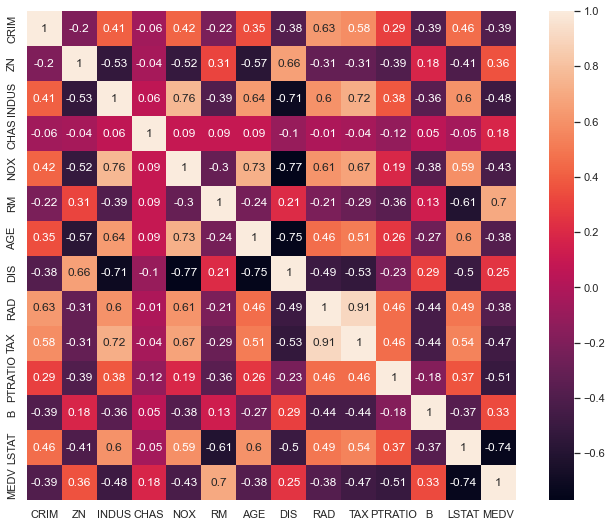

In [36]:
# 白色正相关, 黑色负相关, 红色不相关
f, ax = plt.subplots(figsize=(12, 9))  # 设置画布
sns.heatmap(corr_matrix,
            vmax=1,
            square=True,  # 画热力图
            annot=True  # 是否显示数值
            )
